# Imports

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

pd.reset_option('display.max_rows')


In [16]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cpu device


In [17]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # Convert to grayscale if necessary
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))           # Normalize to mean=0.5, std=0.5 for grayscale
])

train_dataset = datasets.ImageFolder(root='images_dataset_train', transform=transform)
test_dataset = datasets.ImageFolder(root='images_dataset_test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)


In [18]:
print("Classes in train dataset:", train_dataset.classes)
print("Number of classes detected:", len(train_dataset.classes))

Classes in train dataset: ['bw7', 'ecard1', 'ecard2', 'ecard3', 'pl3', 'sm1', 'sm10', 'sm11', 'sm12', 'sm2', 'sm3', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'smp', 'sv1', 'sv2', 'sv4', 'sv4pt5', 'sv6', 'sv7', 'swsh1', 'swsh10', 'swsh12pt5', 'swsh2', 'swsh3', 'swsh4', 'swsh5', 'swsh8', 'swsh9', 'swshp', 'xy5', 'xy8', 'xyp']
Number of classes detected: 36


In [19]:
class CNN(nn.Module):
    def __init__(self,drop):
        super(CNN, self).__init__()
        self.drop = drop

        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),                # Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
            nn.ReLU(inplace=True),                                               # In place ReLU activation layer
            nn.MaxPool2d(kernel_size=2, stride=2),                               # Max pooling layer with window size 2, stride 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),               # Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
            nn.ReLU(inplace=True),                                               # Second In-place ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                               # Max pooling layer with window size 2, stride 2
        )

                                                                                # Since torch.Size([1, 28, 28])
                                                                                # H = 28, W = 28 and C = 1 (Height, Width, number of channels)
                                                                                # After the first pooling step, H=28/2 = 14, W=28/2= 14 and C=1
                                                                                # After the second pooling step, H=14/2=7, W=14/2=7 and C=1
                                                                                # Depth = 64 because size of the kernel in the second conv layer is 64
                                                                                # Dimensions of features 7 * 7 * 64
        self.fully_connected_layer1 = nn.Sequential(
            nn.Linear(3136, 1024),                                               # Fully connected layer with 1024 output channels
            nn.ReLU(inplace= True)                                                # In place ReLU activation layer

       )
        self.dropout = nn.Dropout(p = 0.4)                                        # Dropout layer with drop rate 0.4
        self.fully_connected_layer2 = nn.Linear(1024, 36)                         # Fully connected layer with 10 output channels and 1024 inputs from prev pooling step

    def forward(self, x):
        input = self.convolutional_layers(x)                                     # apply conv layers
        input = input.reshape(-1, 3136)                                          # reshape
        input =  self.fully_connected_layer1(input)                              # apply fc layeer 1
        if(self.drop == True):                                                   # is dropout needed ?
          #print("applied Dropout")
          input = self.dropout(input)

        input = self.fully_connected_layer2(input)                                 # apply fc 2
        return input

# Print net
net = CNN(drop=True).to(device)
print(net)

CNN(
  (convolutional_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer1): Sequential(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fully_connected_layer2): Linear(in_features=1024, out_features=36, bias=True)
)


In [20]:
import torch.optim as optim
from tqdm import tqdm  # For progress bar

# Use the CNN class and training function you've defined

# Initialize the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = CNN(drop=True).to(device)

# Define the training function
def train(train_loader, net, opt='adam', epochs=10, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist = []

    # Select optimizer
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.99)

    # Set model to training mode
    net.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for X, y in tqdm(train_loader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Zero gradients, perform forward pass, compute loss, backward pass, and optimize
            optimizer.zero_grad()
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            epoch_loss += loss.item()
            predictions = outputs.argmax(dim=1)
            correct = (predictions == y).sum().item()
            epoch_accuracy += correct / y.size(0)

        # Average loss and accuracy per epoch
        losslist.append(epoch_loss / len(train_loader))
        acclist.append(epoch_accuracy / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {losslist[-1]:.4f}, Accuracy: {acclist[-1]:.4f}")

    return losslist, acclist


In [21]:
# Set training parameters
epochs = 10
learning_rate = 1e-3
opt = 'adam'

# Train the model
losslist, acclist = train(train_loader, net, opt=opt, epochs=epochs, learning_rate=learning_rate)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:10<00:00,  4.35s/it]


Epoch 1/10, Loss: 3.5084, Accuracy: 0.0664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:13<00:00,  4.46s/it]


Epoch 2/10, Loss: 3.0494, Accuracy: 0.1381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.68s/it]


Epoch 3/10, Loss: 2.5517, Accuracy: 0.1872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.65s/it]


Epoch 4/10, Loss: 2.2944, Accuracy: 0.2294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.64s/it]


Epoch 5/10, Loss: 2.1321, Accuracy: 0.2572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:21<00:00,  4.72s/it]


Epoch 6/10, Loss: 1.9984, Accuracy: 0.2884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.69s/it]


Epoch 7/10, Loss: 1.9174, Accuracy: 0.3153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:25<00:00,  6.85s/it]


Epoch 8/10, Loss: 1.8389, Accuracy: 0.3421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:37<00:00,  5.24s/it]


Epoch 9/10, Loss: 1.7697, Accuracy: 0.3673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:52<00:00,  3.74s/it]

Epoch 10/10, Loss: 1.6946, Accuracy: 0.3931


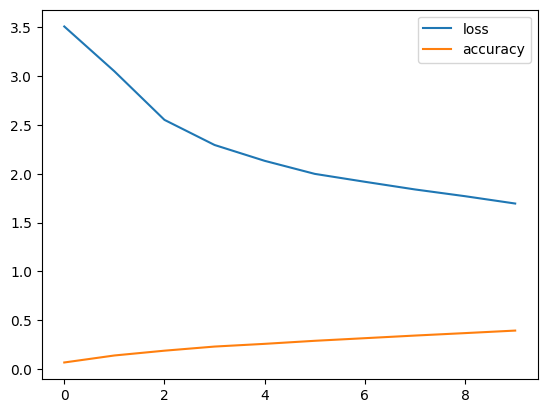

In [22]:
ax1=range(len(losslist))
plt.plot(ax1, losslist, ax1, acclist)
plt.legend(['loss', 'accuracy'])
plt.show()